# 🪐 Project: War Analytics - Clone Army Failure Analysis

## 1. Context
The Republic fights for its survival. Led by Jedi Generals, the Clone Army faces the Separatist forces. The droids are numerous, and battles have seen better days. Recently, soldiers have been failing on the battlefield without a known cause.

The **Jedi High Council** is taking action. Based on information documented by their generals, the Council demands insights from the **War Analytics** team (the Old Republic's BI unit) to staunch the bleeding and keep the galaxy under the command of the Galactic Senate.

## 2. Objective
Use a **Decision Tree** algorithm to classify Clone Troopers based on their physical attributes. The goal is to provide interpretable rules to the Council to identify which batches of clones are prone to failure.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# Set global plotting style for professional visualizations
plt.style.use('ggplot')

In [22]:
# Load the dataset
# Ensure the path matches your local directory structure
df = pd.read_parquet("data/dados_clones.parquet")

# Rename columns from Portuguese to English for the portfolio
column_mapping = {
    "Distância Ombro a ombro": "shoulder_width",
    "Tamanho do crânio": "skull_size",
    "Tamanho dos pés": "feet_size",
    "Massa(em kilos)": "mass_kg",
    "Estatura(cm)": "height_cm",
    "Tempo de existência(em meses)": "lifespan_months",
    "Status ": "status"
}

df = df.rename(columns=column_mapping)

# Preview the data to verify changes
df.head()

,p2o_master_id,mass_kg,General Jedi encarregado,height_cm,shoulder_width,skull_size,feet_size,lifespan_months,status
0,10578986,83.13,Yoda,180.25,Tipo 4,Tipo 1,Tipo 5,0.0,Defeituoso
1,10976676,83.08,Yoda,180.39,Tipo 3,Tipo 2,Tipo 5,0.0,Defeituoso
2,10588329,83.12,Shaak Ti,180.26,Tipo 4,Tipo 5,Tipo 5,0.0,Defeituoso
3,10254411,83.38,Shaak Ti,180.35,Tipo 2,Tipo 2,Tipo 5,0.0,Defeituoso
4,10634458,83.15,Shaak Ti,180.31,Tipo 3,Tipo 2,Tipo 2,0.0,Defeituoso


## 3. Feature Engineering
To train our machine learning model, we need to convert categorical text data into numerical formats.

* **Ordinal Encoding:** Applied to features like `skull_size` and `feet_size`, where the order matters (e.g., Small < Medium < Large).
* **Label Encoding:** Applied to the target variable `status`.

In [23]:
# 1. Define feature groups
features_categorical = [
    "shoulder_width", 
    "skull_size", 
    "feet_size"
]

features_numerical = [
    "mass_kg", 
    "height_cm", 
    "lifespan_months"
]

# 2. Apply Ordinal Encoder to categorical features
# handle_unknown='use_encoded_value' is a best practice for production to handle new categories safely
encoder = OrdinalEncoder()

# Scikit-learn expects 2D arrays, so we transform only the selected columns
# We overwrite the original text columns with the new numerical codes
df[features_categorical] = encoder.fit_transform(df[features_categorical])

# 3. Create the Feature Matrix (X)
# We combine the encoded categorical features with the numerical ones
features = features_categorical + features_numerical
X = df[features]

# 4. Encode the Target (y)
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df['status'])

print("Feature Matrix shape:", X.shape)
print("Target classes:", target_encoder.classes_)

Feature Matrix shape: (1048719, 6)
Target classes: ['Apto' 'Defeituoso']


In [24]:
# Initialize the Decision Tree Classifier
# We use a random_state for reproducibility
clone_tree = tree.DecisionTreeClassifier(random_state=42)

# Fit the model to the data
clone_tree = clone_tree.fit(X, y)

## 4. Deep Dive: The "90% Rule"
Initial observations suggest that **Mass (Weight)** and **Height** are the most significant predictors of clone trooper failure, accounting for nearly 90% of the cases.

To confirm this hypothesis and provide clear parameters to the cloners on Kamino, we will visualize the decision tree restricted to the top 3 levels. This isolates the most critical decision boundaries.

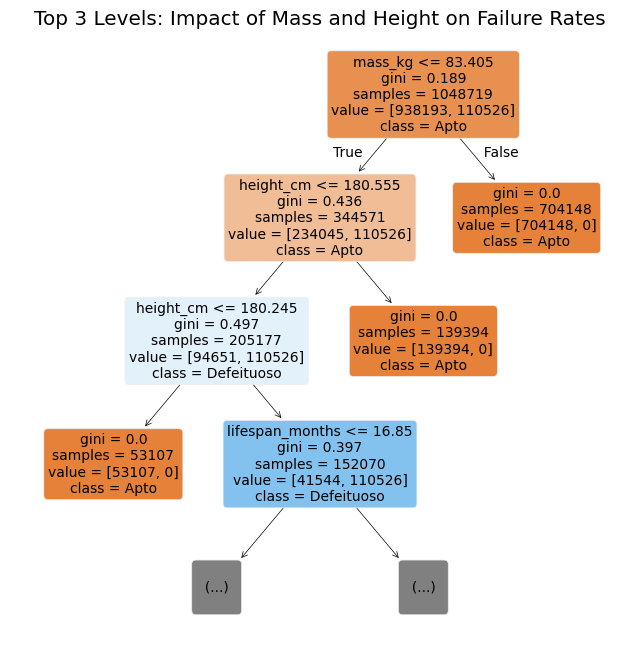

In [25]:
#Plot the tree, but limit the depth to 3 to see the primary rules clearly
plt.figure(dpi=100, figsize=(8, 8))

tree.plot_tree(
    clone_tree,
    feature_names=features,
    class_names=target_encoder.classes_,
    max_depth=3,          # Limit depth to focus on top-level rules
    filled=True,
    rounded=True,
    fontsize=10           # Increase font size for readability
)

plt.title("Top 3 Levels: Impact of Mass and Height on Failure Rates")
plt.show()

### 5. War Analytics Insights

**Executive Summary for the Jedi Council:**
Our analysis confirms that physiological anomalies—specifically **Mass** and **Height**—are the root cause of the recent battlefield failures. These two variables appear at the root of our decision tree, indicating they distinguish functional clones from defective ones with high accuracy.

**Key Findings:**
* **The Mass Threshold:** The primary split in the data occurs based on `mass_kg`. Clones falling outside the standard weight (>83.405 kg) distribution are significantly more likely to malfunction.
* **Height Correlation:** Among clones within the acceptable weight range, `height_cm` serves as the secondary filter (>180.555 cm). Deviations here correlate strongly with the remaining failure cases.

**Conclusion:**
Approximately 80% of the defects can be screened by checking these two variables alone. We recommend immediate implementation of a **Weight > 83.405 kg** + **Height > 180.555 cm** pass/fail gate at the Kamino facility production line.
